In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# loading the processed dataset
df = pd.read_csv("../data/processed/water_treatment_clean.csv")
df.head()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,pH_Status,TDS_Status,Turbidity_Status,Recommended_Treatment
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0,Normal,High,Normal,RO Filtration + UV Purification
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0,Abnormal,High,Normal,Boiling / pH Adjustment + RO Filtration + UV P...
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0,Normal,High,Normal,RO Filtration + UV Purification
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0,Normal,High,Normal,RO Filtration + UV Purification
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,Abnormal,High,Normal,Boiling / pH Adjustment + RO Filtration + UV P...


In [5]:
# defining features and target variable

# Drop non-numeric and recommendation columns
X = df.drop(columns=[
    "Potability",
    "Recommended_Treatment",
    "pH_Status",
    "TDS_Status",
    "Turbidity_Status"
])

y = df["Potability"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (3276, 9)
Target shape: (3276,)


In [7]:
#splitting the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 2620
Testing samples: 656


In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_sm).value_counts())


Before SMOTE: Potability
0    1598
1    1022
Name: count, dtype: int64
After SMOTE: Potability
0    1598
1    1598
Name: count, dtype: int64


In [25]:
# basreline model using Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))


Decision Tree Accuracy: 0.6417682926829268


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Accuracy: 0.6478658536585366


In [31]:
from xgboost import XGBClassifier

neg, pos = y_train.value_counts()
scale = neg / pos

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_prob >= 0.4).astype(int)


print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Accuracy: 0.6189024390243902


In [33]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    class_weight='balanced',
    random_state=42
)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 1022, number of negative: 1598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2620, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM Accuracy: 0.6234756097560976


In [37]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix,
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_advanced(name, model, X_test, y_test, threshold=0.5):
    print(f"\n{name} Evaluation (threshold={threshold})")

    # Probabilities
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    # Metrics
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

    print("\nClassification Report:\n",
          classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()




Random Forest Evaluation (threshold=0.45)
Accuracy : 0.6067073170731707
Precision: 0.49707602339181284
Recall   : 0.6640625
F1 Score : 0.568561872909699
ROC-AUC  : 0.67244140625

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.57      0.64       400
           1       0.50      0.66      0.57       256

    accuracy                           0.61       656
   macro avg       0.61      0.62      0.60       656
weighted avg       0.64      0.61      0.61       656



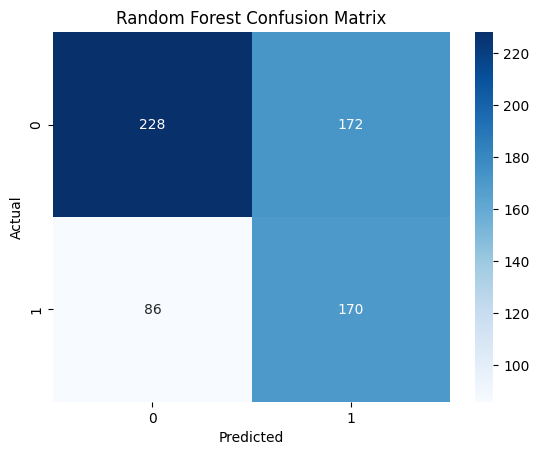

In [38]:
evaluate_model_advanced("Random Forest", rf, X_test, y_test, threshold=0.45)


In [29]:
df['Potability'].value_counts(normalize=True)


Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

In [40]:
# script to save the best model
import joblib

final_model = {
    "model": rf,           # trained Random Forest model
    "threshold": 0.45,     # optimized decision threshold
    "features": X.columns.tolist()  # feature order safety
}

joblib.dump(final_model, "../models/classification_model.pkl")

print("✅ Final ML model and threshold saved successfully")


✅ Final ML model and threshold saved successfully
